# ResNet-50 Based Hand Pose Estimation
This is a Hand Pose Estimation model based on the ResNet-50 architecture.
The goal of this model is to predict the x, y, and z coordinate values for 21 landmark points of the left and right hands extracted by mediapipe, respectively, in a given hand image.

In [59]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.metrics import accuracy_score

## 1. Data Load and Preprocessing

In [60]:
music_folder = 'music'
file_list = os.listdir(music_folder)

# 이미지 파일만 필터링 (확장자가 .jpg 인 파일)
image_files = [f for f in file_list if f.endswith('.jpg')]

# 파일 이름을 정렬하여 순서대로 처리
image_files.sort()

# 숫자를 1부터 시작하여 새로운 이름으로 변경
for i, image_file in enumerate(image_files, start=1):
    old_path = os.path.join(music_folder, image_file)
    
    # 현재 파일 이름에서 "output_music4-" 다음에 오는 숫자를 추출
    match = re.search(r'music4-(\d+)', image_file)
    if match:
        number = int(match.group(1))
        
        # 숫자를 1부터 시작하는 값으로 변경하여 새로운 이름 생성
        new_number = i
        new_file_name = f"{new_number}.jpg"
        
        # 새로운 파일 경로 생성
        new_path = os.path.join(music_folder, new_file_name)
        
        # 파일 이름 변경
        os.rename(old_path, new_path)
        print(f"Renamed {old_path} to {new_path}")

print("File renaming complete.")


File renaming complete.


In [57]:
# Custom Dataset 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 이미지 파일 이름 설정 (1부터 시작하므로 idx + 1)
        img_name = os.path.join(self.img_dir, str(idx + 1) + ".jpg")
        image = Image.open(img_name)
        
        # 해당 행의 라벨 데이터 (x, y, z 좌표)를 추출
        labels = torch.tensor(self.data.iloc[idx].values, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, labels


# 이미지 전처리를 원하는대로 수정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 및 DataLoader 설정
dataset = CustomDataset(csv_path="hand_result.csv", img_dir="music/", transform=transform)

batch_size=64
# 데이터를 6:2:2 비율로 분할
total_dataset_size = len(dataset)
train_size = int(0.6 * total_dataset_size)
val_size = int(0.2 * total_dataset_size)
test_size = total_dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader 생성
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# 분할된 데이터셋의 크기 확인
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 1979
Validation dataset size: 659
Test dataset size: 661


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample 1:
Image shape: torch.Size([3, 224, 224])
Labels shape: torch.Size([126])
Labels: tensor([ 9.1984e+02,  5.9711e+02,  1.6400e-07,  8.8533e+02,  5.7429e+02,
        -7.7183e-03,  8.6390e+02,  5.4255e+02, -1.2022e-02,  8.4643e+02,
         5.2003e+02, -1.5319e-02,  8.2769e+02,  5.0678e+02, -1.9018e-02,
         9.1352e+02,  5.1495e+02, -1.0912e-02,  9.2157e+02,  4.7970e+02,
        -1.5198e-02,  9.2582e+02,  4.5679e+02, -1.8796e-02,  9.2878e+02,
         4.3962e+02, -2.1853e-02,  9.3928e+02,  5.1859e+02, -1.1645e-02,
         9.5643e+02,  4.8243e+02, -1.3955e-02,  9.6571e+02,  4.5922e+02,
        -1.6956e-02,  9.7340e+02,  4.4082e+02, -2.0138e-02,  9.5720e+02,
         5.2808e+02, -1.3024e-02,  9.7511e+02,  4.9545e+02, -1.7607e-02,
         9.8367e+02,  4.7523e+02, -2.2643e-02,  9.9001e+02,  4.5795e+02,
        -2.6975e-02,  9.6750e+02,  5.4179e+02, -1.4780e-02,  9.8946e+02,
         5.2804e+02, -2.1489e-02,  1.0025e+03,  5.1779e+02, -2.5356e-02,
         1.0136e+03,  5.0811e+02, -

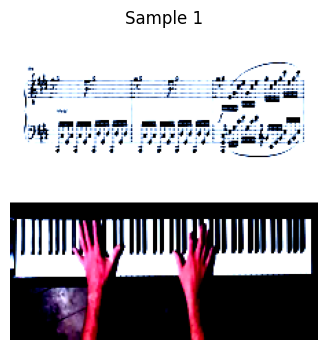

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample 2:
Image shape: torch.Size([3, 224, 224])
Labels shape: torch.Size([126])
Labels: tensor([ 7.5422e+02,  5.9099e+02,  1.2400e-07,  7.1550e+02,  5.7478e+02,
        -8.2135e-03,  6.9653e+02,  5.4587e+02, -1.1953e-02,  6.8816e+02,
         5.1687e+02, -1.4461e-02,  6.7624e+02,  4.9687e+02, -1.6509e-02,
         7.3089e+02,  5.0983e+02, -6.9831e-03,  7.3378e+02,  4.7620e+02,
        -1.0923e-02,  7.3444e+02,  4.5521e+02, -1.4321e-02,  7.3405e+02,
         4.3928e+02, -1.6862e-02,  7.5704e+02,  5.0878e+02, -6.5610e-03,
         7.6663e+02,  4.7244e+02, -8.2837e-03,  7.6968e+02,  4.5068e+02,
        -1.0719e-02,  7.7098e+02,  4.3447e+02, -1.3064e-02,  7.7635e+02,
         5.1405e+02, -7.0839e-03,  7.8589e+02,  4.8059e+02, -1.0668e-02,
         7.8719e+02,  4.6067e+02, -1.3500e-02,  7.8629e+02,  4.4547e+02,
        -1.5687e-02,  7.9043e+02,  5.2335e+02, -8.1948e-03,  8.0499e+02,
         5.0237e+02, -1.1815e-02,  8.1027e+02,  4.8876e+02, -1.3074e-02,
         8.1271e+02,  4.7739e+02, -

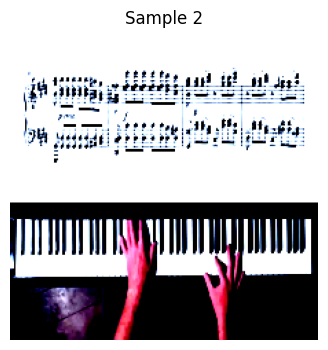

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample 3:
Image shape: torch.Size([3, 224, 224])
Labels shape: torch.Size([126])
Labels: tensor([ 7.0818e+02,  6.4086e+02,  1.1100e-07,  7.5013e+02,  6.2236e+02,
        -9.1207e-03,  7.7182e+02,  5.8928e+02, -1.3146e-02,  7.8411e+02,
         5.6248e+02, -1.6300e-02,  8.0182e+02,  5.5041e+02, -1.9820e-02,
         7.3711e+02,  5.5285e+02, -1.2881e-02,  7.4054e+02,  5.1860e+02,
        -1.8694e-02,  7.4108e+02,  4.9460e+02, -2.3279e-02,  7.4003e+02,
         4.7548e+02, -2.7490e-02,  7.0951e+02,  5.5177e+02, -1.2640e-02,
         6.9492e+02,  5.1699e+02, -1.8653e-02,  6.8474e+02,  4.9473e+02,
        -2.3105e-02,  6.7503e+02,  4.7728e+02, -2.6786e-02,  6.8793e+02,
         5.5894e+02, -1.2819e-02,  6.7429e+02,  5.2429e+02, -1.9511e-02,
         6.6556e+02,  5.0260e+02, -2.4586e-02,  6.5730e+02,  4.8403e+02,
        -2.8307e-02,  6.7326e+02,  5.7131e+02, -1.3553e-02,  6.5518e+02,
         5.5005e+02, -2.1612e-02,  6.4356e+02,  5.3495e+02, -2.6245e-02,
         6.3383e+02,  5.2203e+02, -

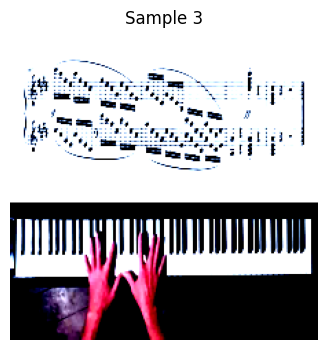

In [61]:
import matplotlib.pyplot as plt

# Load Samples
num_samples_to_display = 3
samples = []
for i in range(num_samples_to_display):
    sample_idx = i  # index
    image, labels = test_dataset[sample_idx]
    samples.append((image, labels))

# Visualization
for i, (image, labels) in enumerate(samples):
    print(f"Sample {i + 1}:")
    print("Image shape:", image.shape)
    print("Labels shape:", labels.shape)
    print("Labels:", labels)
    
    plt.figure(figsize=(4, 4))
    plt.imshow(image.permute(1, 2, 0))  # 이미지 형식 변경 (C, H, W) -> (H, W, C)
    plt.title(f"Sample {i + 1}")
    plt.axis("off")
    plt.show()

## 2. Define Model and Train Model

In [62]:
# 모델 클래스 정의
class HandPoseResNet(nn.Module):
    def __init__(self, num_keypoints_per_hand=21):
        super(HandPoseResNet, self).__init__()
        # ResNet-50
        self.resnet = models.resnet50(pretrained=True)
        
        # 마지막 fully connected layer를 변경하여 출력 크기를 조정
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, num_keypoints_per_hand * 3 * 2)  # (왼손 + 오른손) * (x, y, z) 좌표 (21개 * 3 * 2)
        )

    def forward(self, x):
        return self.resnet(x)

In [117]:
# CUDA ~ Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델을 GPU로 이동
model = HandPoseResNet(num_keypoints_per_hand=21).to(device)

# 손실 함수, 옵티마이저 설정
criterion = nn.L1Loss()  # L1 손실 함수 사용 (절대 오차)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 에포크 수 설정
num_epochs = 50

train_loss_for_plot = []
val_loss_for_plot = []

for epoch in range(num_epochs):
    # 모델을 훈련 모드로 설정
    model.train()
    
    # 에포크마다의 훈련 손실과 검증 손실을 저장할 리스트 초기화
    train_losses = []

    # 훈련 데이터로 모델 훈련
    train_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss)
    
    # 모델을 평가 모드로 설정
    model.eval()
    
    # 검증 데이터로 모델 평가
    val_losses = []
    
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss.item())
    
    # 에포크마다 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {loss.item():.4f}")
    print(f"Validation Loss: {np.mean(val_losses):.4f}")
    train_loss_for_plot.append(f'{loss.item():.4f}')
    val_loss_for_plot.append(f'{np.mean(val_losses):.4f}')

C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50]
Train Loss: 368.1437
Validation Loss: 348.6017
Epoch [2/50]
Train Loss: 312.7700
Validation Loss: 304.5531
Epoch [3/50]
Train Loss: 234.5847
Validation Loss: 234.0246
Epoch [4/50]
Train Loss: 153.6790
Validation Loss: 125.6392
Epoch [5/50]
Train Loss: 79.5420
Validation Loss: 175.0041
Epoch [6/50]
Train Loss: 63.1656
Validation Loss: 85.4503
Epoch [7/50]
Train Loss: 64.0265
Validation Loss: 72.2277
Epoch [8/50]
Train Loss: 61.1809
Validation Loss: 63.5768
Epoch [9/50]
Train Loss: 62.6716
Validation Loss: 62.0121
Epoch [10/50]
Train Loss: 56.3538
Validation Loss: 65.4722
Epoch [11/50]
Train Loss: 65.9227
Validation Loss: 64.6561
Epoch [12/50]
Train Loss: 65.5680
Validation Loss: 59.7191
Epoch [13/50]
Train Loss: 58.9350
Validation Loss: 65.9797
Epoch [14/50]
Train Loss: 58.6138
Validation Loss: 75.7422
Epoch [15/50]
Train Loss: 59.2965
Validation Loss: 60.1431
Epoch [16/50]
Train Loss: 59.2770
Validation Loss: 62.6877
Epoch [17/50]
Train Loss: 60.3258
Validation Loss: 57.97

## 3. Evaluate Model

In [129]:
from sklearn.metrics import mean_squared_error

# 모델을 평가 모드로 설정
model.eval()

# 데이터 로더 설정 (테스트)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# 평균 제곱 오차를 저장할 빈 리스트 생성
test_losses = []

# 예측된 라벨과 실제 라벨을 저장할 리스트 생성
predicted_labels = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        test_loss = criterion(outputs, labels)
        test_losses.append(test_loss.item())

        predicted_labels.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# 테스트 데이터에 대한 평균 제곱 오차 계산
test_mse = np.mean(test_losses)

# 평균 제곱 오차 출력
print(f"Test Mean Squared Error (MSE): {test_mse:.4f}")

# 예측된 라벨과 실제 라벨을 사용하여 추가 평가 지표 계산 가능
# 예를 들어, R-squared (R^2) 등을 계산하여 모델의 성능을 평가할 수 있습니다.

Test Mean Squared Error (MSE): 36.0714


In [136]:
print(f'Test Dataset 갯수: {len(predicted_labels)}')
print(f'예측 레이블 수: {len(predicted_labels[0])}')
print(f'0번째 idx를 가진 testdata에 대한 랜드마크 예측 값 {predicted_labels[0]}')

Test Dataset 갯수: 661
예측 레이블 수: 126
0번째 idx를 가진 testdata에 대한 랜드마크 예측 값 [ 9.1180957e+02  6.1231854e+02  3.6083707e-01  8.7073328e+02
  5.8921234e+02 -1.5973382e-01  8.5039575e+02  5.5487164e+02
 -1.2278560e-01  8.3511572e+02  5.2663855e+02 -2.0860358e-01
  8.1704077e+02  5.0843600e+02  3.1547573e-01  8.9398486e+02
  5.2423474e+02  5.3042614e-01  9.0011761e+02  4.8880756e+02
  1.8894817e-01  9.0124109e+02  4.6765829e+02 -6.4361721e-01
  9.0246301e+02  4.5171539e+02  3.5169938e-01  9.2419940e+02
  5.2919958e+02  7.8206278e-02  9.3705951e+02  4.9203815e+02
 -1.8599395e-01  9.4202954e+02  4.6846997e+02  2.1809462e-01
  9.4426764e+02  4.4988141e+02  5.5878079e-01  9.4624774e+02
  5.3798853e+02 -2.4960598e-02  9.6033246e+02  5.0385513e+02
 -2.3267421e-01  9.6346619e+02  4.8121011e+02  3.3546770e-01
  9.6533923e+02  4.6290649e+02 -3.3491766e-01  9.6210706e+02
  5.5090448e+02 -2.8438857e-01  9.7853278e+02  5.3031555e+02
 -1.3326716e-01  9.8787354e+02  5.1591919e+02 -6.0354573e-01
  9.9167053e+02

## 4. Test Model

Original Image


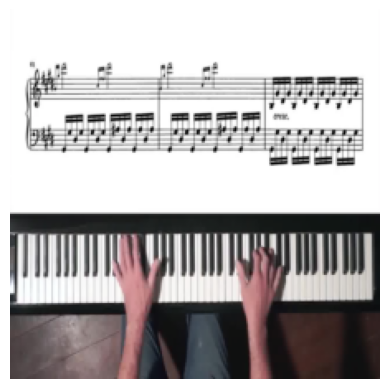

Model Predictions:
[ 7.09379456e+02  6.03652893e+02 -1.69214994e-01  7.05194458e+02
  5.85007080e+02 -4.77291550e-03  7.02677185e+02  5.53661804e+02
  9.99539346e-02  7.01088806e+02  5.26306030e+02  8.98953062e-03
  6.99048950e+02  5.08830383e+02 -6.19435720e-02  7.06272949e+02
  5.21930542e+02 -9.10406262e-02  7.06255981e+02  4.86219849e+02
 -1.23236351e-01  7.05491272e+02  4.67351196e+02 -8.40492398e-02
  7.04734375e+02  4.55206635e+02 -1.01848423e-01  7.08992920e+02
  5.22713440e+02  1.97526157e-01  7.08348145e+02  4.84018768e+02
  2.86012013e-02  7.08072754e+02  4.62405701e+02 -1.70827582e-01
  7.07726013e+02  4.47646729e+02 -2.17752054e-01  7.11125732e+02
  5.29259277e+02 -1.12901837e-01  7.10013794e+02  4.93707428e+02
  4.26557511e-02  7.09340515e+02  4.73715149e+02 -1.17524944e-01
  7.08466675e+02  4.59260834e+02 -2.99888495e-02  7.13130737e+02
  5.39379578e+02 -2.22704396e-01  7.13898682e+02  5.15155151e+02
  1.42593626e-02  7.13777161e+02  5.00886841e+02 -6.18211925e-02
  7.13

In [115]:
import csv
# 평균과 표준 편차
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# 전처리 역변환 함수
def reverse_normalize(image):
    reverse_normalize = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[1 / std[0], 1 / std[1], 1 / std[2]]),
        transforms.Normalize(mean=[-mean[0], -mean[1], -mean[2]], std=[1, 1, 1])
    ])
    return reverse_normalize(image)

# 예측을 역 정규화하여 원래 값으로 변환
sample_idx = 10  # 확인하고 싶은 test data의 idx
original_image = reverse_normalize(test_dataset[sample_idx][0])  # 입력 이미지 역 정규화
predicted_values = predictions[sample_idx]  # 모델 예측 값

# 원본 이미지와 모델 예측 값을 출력
print(f"Original Image")
plt.imshow(original_image.permute(1, 2, 0))
plt.axis("off")
plt.show()

# 1.csv 파일 경로 설정
csv_file = '1.csv'

# 라벨 값을 1.csv 파일에 한 행에 모두 저장
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(predicted_values)

print("Model Predictions:")
print(predicted_values)